# Cuisine Classifier

@Noah Meißner 01.06.2025

Source Dataset: https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset?resource=download

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import joblib  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import random
from foodrec.config.structure.dataset_enum import DatasetEnum
from foodrec.tools.ingredient_normalizer import IngredientNormalisation

## Download and Import Dataset

Due to the Data structure we can use only the Training Set, because the test set does not include the cuisine

In [2]:
path = kagglehub.dataset_download("kaggle/recipe-ingredients-dataset")

In [3]:
train_path = path +"/train.json"


In [4]:
train_data = pd.read_json(train_path)


In [5]:
regions = {
    "central_europe": ["british", "french", "greek", "irish", "italian", "russian", "spanish"],
    "north_america": ["cajun_creole", "southern_us", ],
    "asia": ["chinese", "filipino", "indian", "japanese", "korean", "thai", "vietnamese"],
    "middle_east": ["moroccan"],
    "latin_america": ["mexican", "jamaican", "brazilian"]
}

cuisine_to_region = {cuisine: region for region, cuisines in regions.items() for cuisine in cuisines}


In [6]:
def ingredients_to_text_single(ingredients, embedder, cache):
    exclude = {'salt', 'onions', 'olive oil', 'sugar', 'water'}
    filtered_ingredients = []

    for ing in ingredients:
        ing_lower = ing.lower()
        if ing_lower in exclude: 
            continue

        # Check cache
        if ing_lower in cache:
            embedding_result = cache[ing_lower]
        else:
            embedding_result = embedder.advanced_hybrid_search(ing, 1)[0]
            try:
                if len(embedding_result) == 1:
                    print(ing, embedder.advanced_hybrid_search(ing, 1), embedding_result)
                cache[ing_lower] = embedding_result
            except:
                print(embedding_result)

        filtered_ingredients.append(embedding_result)

    random.shuffle(filtered_ingredients)
    return " ".join(filtered_ingredients)


In [7]:
from tqdm import tqdm
tqdm.pandas()  # aktiviert tqdm-Integration für Pandas

cuisine_to_region = {cuisine: region for region, cuisines in regions.items() for cuisine in cuisines}
train_data['regions'] = train_data['cuisine'].map(cuisine_to_region)
embedder = IngredientNormalisation(DatasetEnum.KOCHBAR)
embedding_cache = {}
raw_ingredients = train_data['ingredients']
train_data['ingredients'] = train_data['ingredients'].progress_map(lambda x: ingredients_to_text_single(x, embedder, embedding_cache))
X = train_data.drop(columns=[ 'regions', 'cuisine'])  # alle anderen Spalten außer 'region'
y = train_data['regions']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp
)

2025-07-28 17:30:58,786 - foodrec.data.load_ingredient_embeddings - INFO - EmbeddingLoader initialized with path: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_KOCHBAR.csv
2025-07-28 17:30:58,787 - foodrec.data.load_ingredient_embeddings - INFO - Starting embedding retrieval process...
2025-07-28 17:30:58,787 - foodrec.data.load_ingredient_embeddings - INFO - ✓ Found existing embeddings file: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_KOCHBAR.csv
2025-07-28 17:30:58,787 - foodrec.data.load_ingredient_embeddings - INFO - Loading existing embeddings...


####################Load Embeddings####################


100%|██████████| 39774/39774 [33:51<00:00, 19.58it/s]  


## Descriptive Analysis

- Oriented on the following Analysis: https://www.kaggle.com/code/suraj5424/cuisine-prediction-semantic-solution

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_25053/1689099127.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cuisine', data=train_data, palette='viridis')


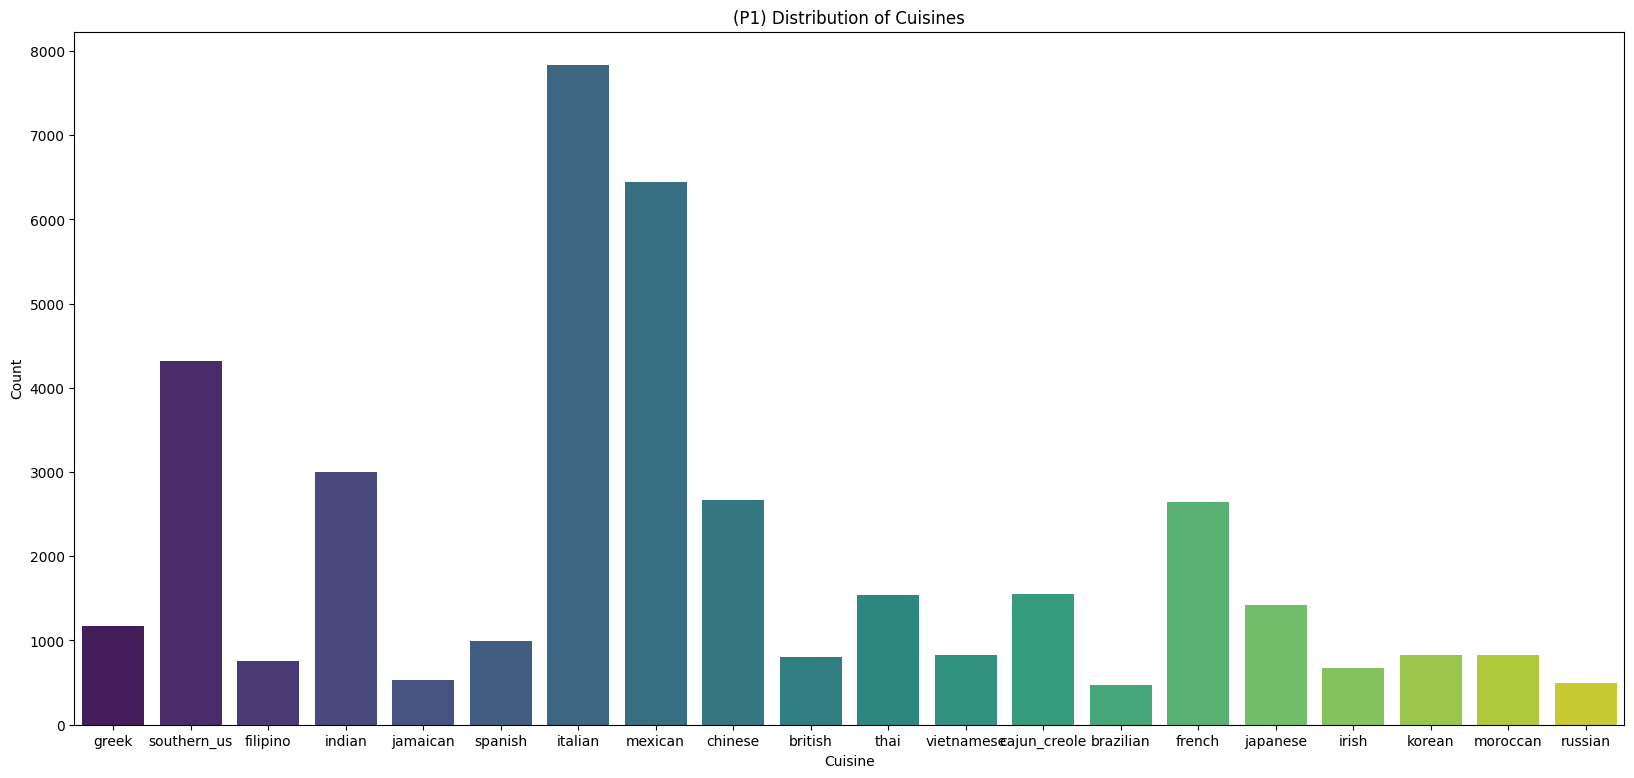

In [8]:
plt.figure(figsize=(20, 9))
sns.countplot(x='cuisine', data=train_data, palette='viridis')
plt.title('(P1) Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.show()


/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_25053/3562020049.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='regions', data=train_data, palette='viridis')


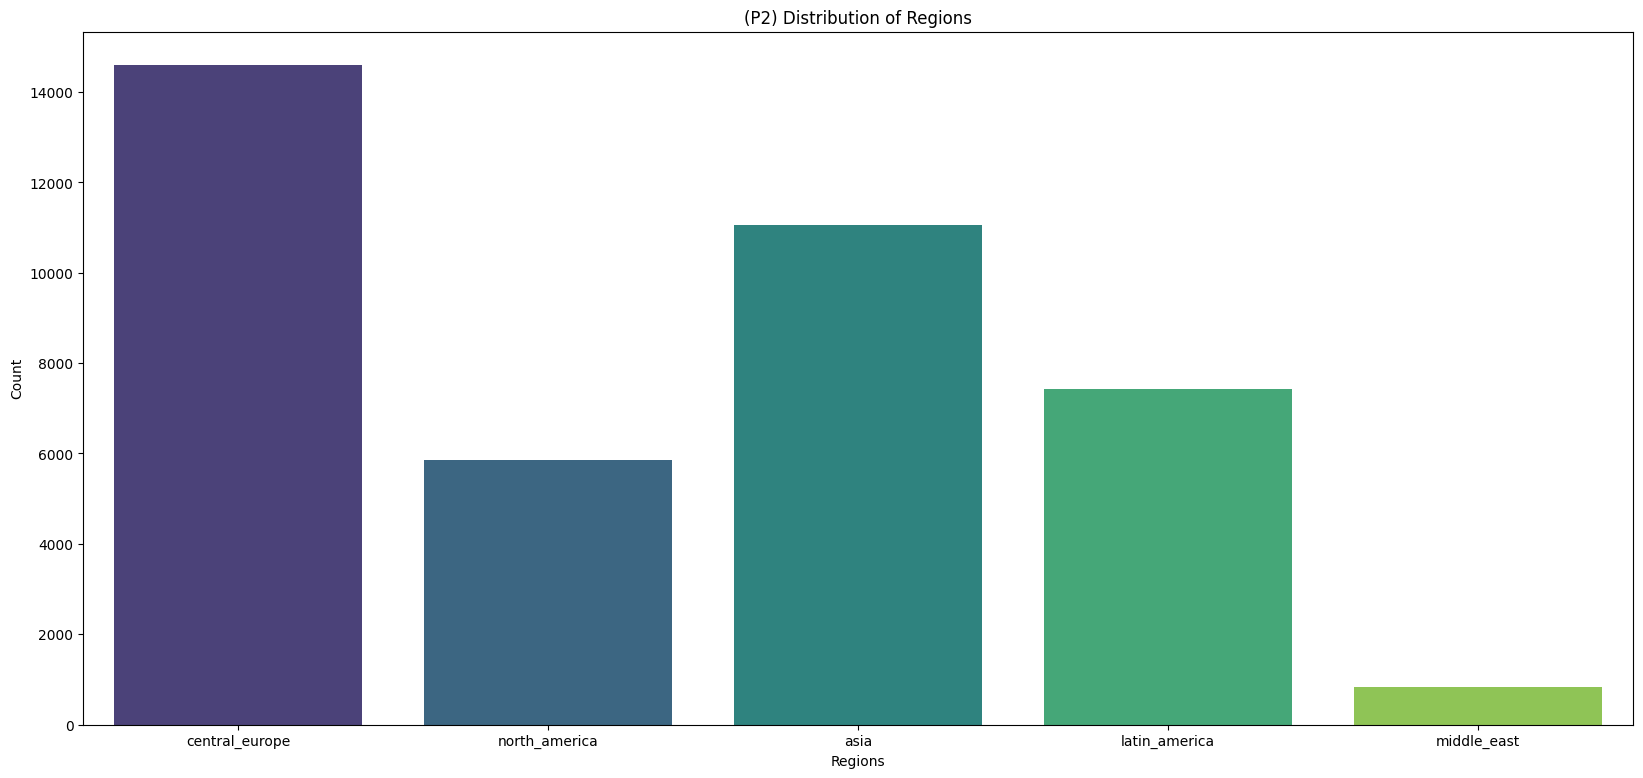

In [9]:
plt.figure(figsize=(20, 9))
sns.countplot(x='regions', data=train_data, palette='viridis')
plt.title('(P2) Distribution of Regions')
plt.xlabel('Regions')
plt.ylabel('Count')
plt.show()

### Analysis P1 and P2
Due to the significant imbalance between the categories, we combine different country cuisines with regional cuisines in order to classify the data more accurately.

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_25053/2075333.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='regions', y=train_data['ingredients'].apply(len), data=train_data, palette='Set3')


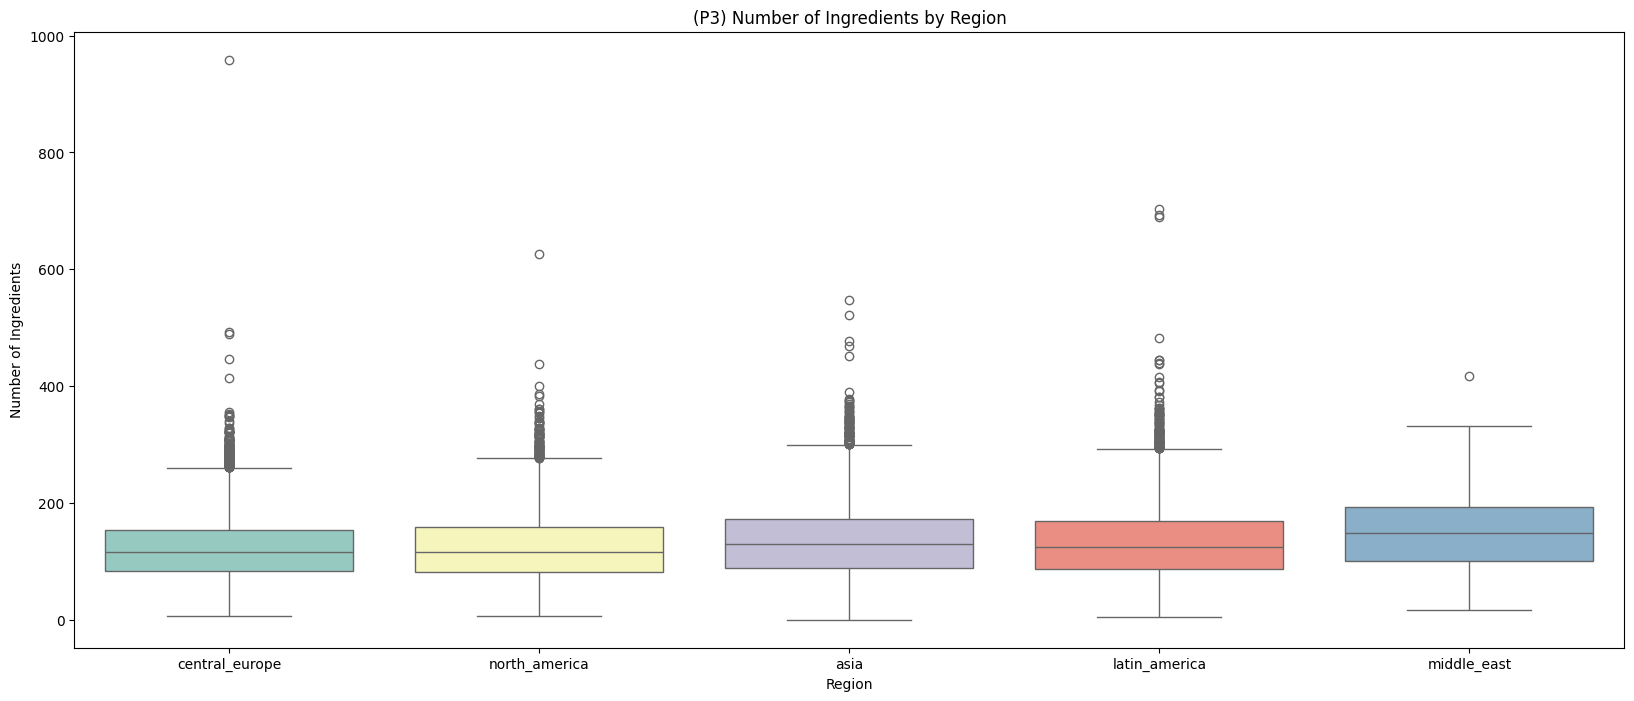

In [10]:
plt.figure(figsize=(20,8))
sns.boxplot(x='regions', y=train_data['ingredients'].apply(len), data=train_data, palette='Set3')
plt.title('(P3) Number of Ingredients by Region')
plt.xlabel('Region')
plt.ylabel('Number of Ingredients')
plt.show()


/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_25053/3013369959.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ingredient', data=ingredient_counts.head(20), palette='viridis')


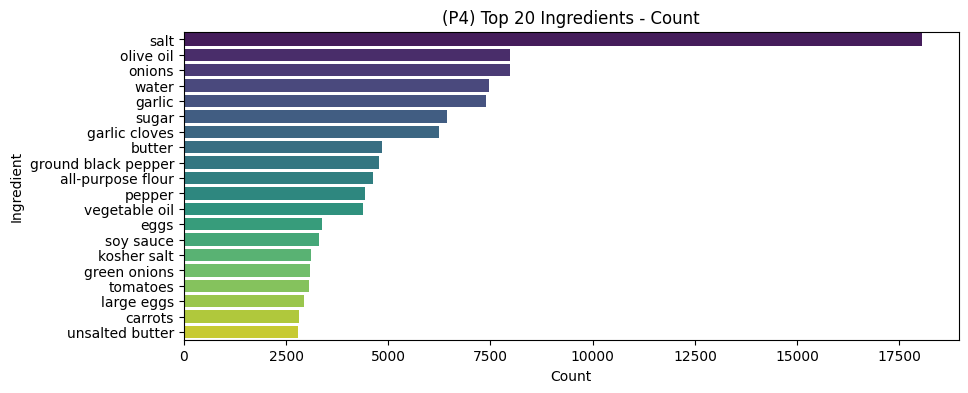

In [11]:
all_ingredients = [ingredient for ingredients_list in raw_ingredients for ingredient in ingredients_list]

ingredient_counts = pd.Series(all_ingredients).value_counts().reset_index()
ingredient_counts.columns = ['ingredient', 'count']
# Plot the count of ingredients
plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='ingredient', data=ingredient_counts.head(20), palette='viridis')
plt.title('(P4) Top 20 Ingredients - Count')
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.show()


#### Analysis (P3) and (P4)
P3 shows, that the number of ingredients per dish are balanced, which makes it comparable to each other <br>
P4 shows that ingredients, like salt are mostly in every dish, which makes it important to preprocess the data, to only have important criterias in the ingredient list

## Model Training

### Random Forest Classifier

In [8]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2))),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'  
    ))
])

pipeline.fit(X_train['ingredients'], y_train)

y_pred = pipeline.predict(X_test['ingredients'])

print("🔍 Classification Report (Test Split):")
print(classification_report(y_test, y_pred))

print("✅ Accuracy (Test Split):", accuracy_score(y_test, y_pred))


🔍 Classification Report (Test Split):
                precision    recall  f1-score   support

          asia       0.91      0.92      0.92      2210
central_europe       0.81      0.94      0.87      2922
 latin_america       0.91      0.82      0.87      1486
   middle_east       0.92      0.47      0.62       164
 north_america       0.87      0.65      0.75      1173

      accuracy                           0.86      7955
     macro avg       0.88      0.76      0.80      7955
  weighted avg       0.87      0.86      0.86      7955

✅ Accuracy (Test Split): 0.8631049654305468


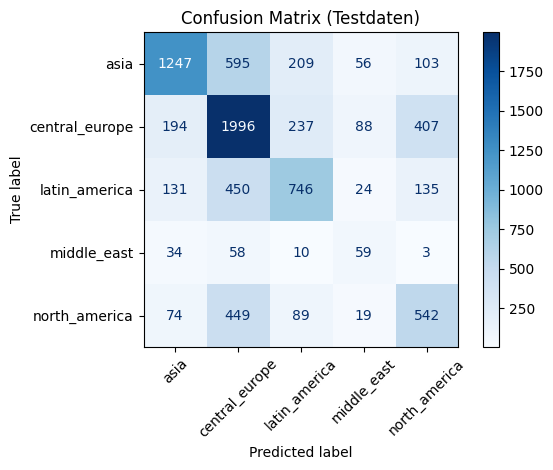

In [9]:
# --- 🔹 Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Testdaten)")
plt.tight_layout()
plt.show()


### XGBClassifier

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X['ingredients'])
X_test_vectorized = vectorizer.transform(X_test['ingredients'])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
reports = []

best_acc = 0
best_model = None

all_y_true = []
all_y_pred = []

for fold, (train_index, val_index) in enumerate(skf.split(X_vectorized, y_encoded), 1):
    X_train_fold, X_val_fold = X_vectorized[train_index], X_vectorized[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]
    
    model = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
    
    y_val_pred = model.predict(X_val_fold)
    
    acc = accuracy_score(y_val_fold, y_val_pred)
    report = classification_report(y_val_fold, y_val_pred, target_names=label_encoder.classes_)
    
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Classification Report:\n{report}")
    
    accuracies.append(acc)
    reports.append(report)
    
    if acc > best_acc:
        best_acc = acc
        best_model = model

    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_val_pred)

print(f"\nAverage Accuracy over 5 folds: {np.mean(accuracies):.4f}")
print(f"Best Fold Accuracy: {best_acc:.4f}")

overall_report = classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_)
print("\nOverall Classification Report (all folds combined):")
print(overall_report)

joblib.dump(best_model, "model/cuisine_classifier.joblib")
joblib.dump(vectorizer, "model/vectorizer.joblib")
joblib.dump(label_encoder, "model/label_encoder.joblib")

print("Bestes Modell gespeichert als 'best_xgb_model.joblib'")


Fold 1 Accuracy: 0.8659
Fold 1 Classification Report:
                precision    recall  f1-score   support

          asia       0.94      0.90      0.92      2210
central_europe       0.81      0.94      0.87      2922
 latin_america       0.90      0.82      0.86      1486
   middle_east       0.88      0.61      0.72       164
 north_america       0.85      0.71      0.77      1173

      accuracy                           0.87      7955
     macro avg       0.88      0.80      0.83      7955
  weighted avg       0.87      0.87      0.86      7955

Fold 2 Accuracy: 0.8732
Fold 2 Classification Report:
                precision    recall  f1-score   support

          asia       0.95      0.90      0.92      2210
central_europe       0.82      0.94      0.88      2922
 latin_america       0.91      0.84      0.87      1486
   middle_east       0.82      0.71      0.76       164
 north_america       0.84      0.71      0.77      1173

      accuracy                           0.87  

In [9]:
test_predictions = best_model.predict(X_test_vectorized)

test_pred_labels = label_encoder.inverse_transform(test_predictions)

test_accuracy = accuracy_score(y_test, test_pred_labels)

conf_matrix_test = confusion_matrix(y_test, test_pred_labels)

class_report_test = classification_report(y_test, test_pred_labels)

print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test Set):")
print(class_report_test)

Test Accuracy: 0.89

Classification Report (Test Set):
                precision    recall  f1-score   support

          asia       0.96      0.92      0.94      2210
central_europe       0.84      0.95      0.89      2922
 latin_america       0.92      0.87      0.90      1486
   middle_east       0.92      0.80      0.86       164
 north_america       0.89      0.75      0.81      1173

      accuracy                           0.89      7955
     macro avg       0.91      0.86      0.88      7955
  weighted avg       0.90      0.89      0.89      7955



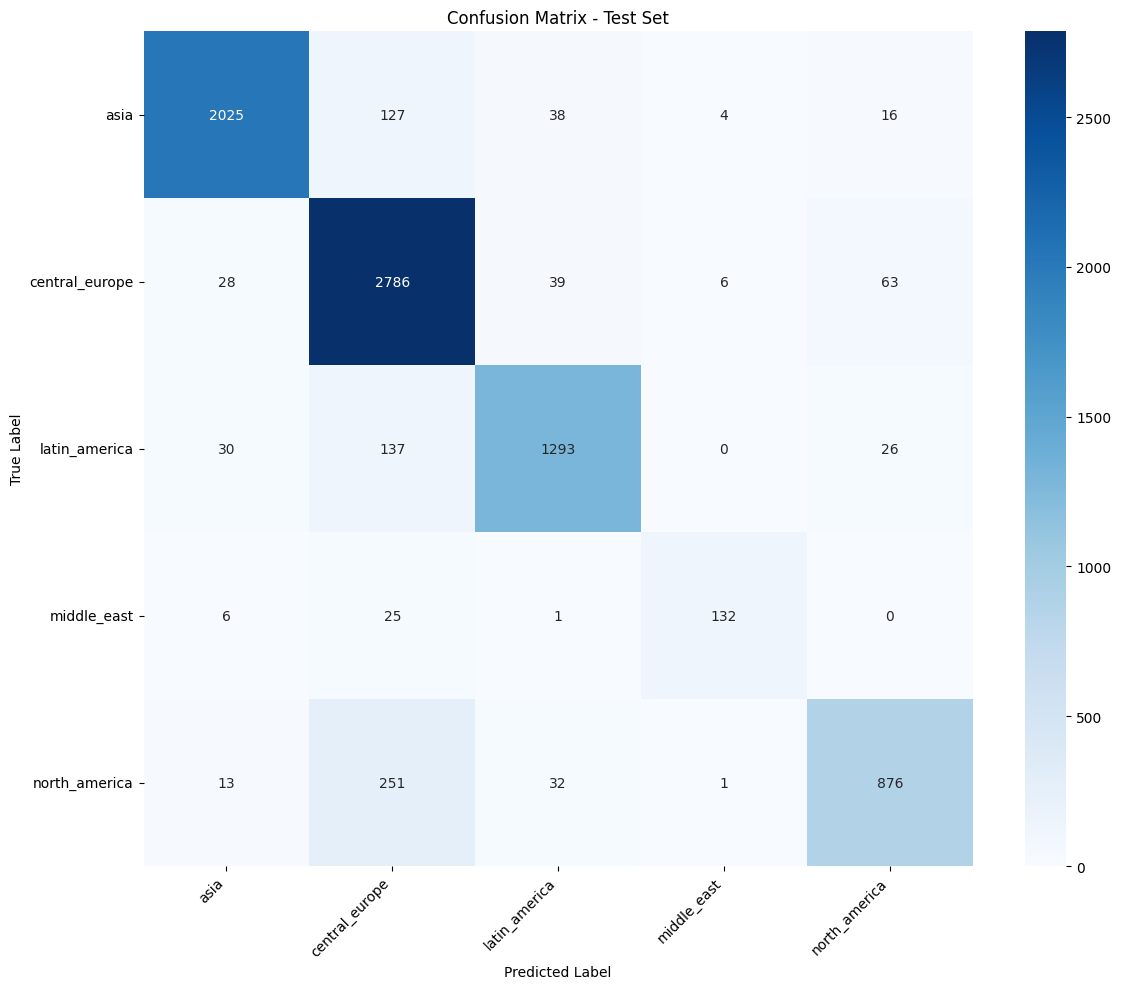

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Analyse Cusisine Datasets

In [21]:
import pandas as pd
import numpy as np
from foodrec.config.structure.paths import DATASET_PATHS

In [22]:
df_all_recipe = pd.read_csv(DATASET_PATHS / "cuisine_ALL_RECIPE.csv")
df_kochbar = pd.read_csv(DATASET_PATHS / "cuisine_KOCHBAR.csv")

In [23]:
df_all_recipe.head()

,Unnamed: 0,recipe_href,recipe_name,description,rating_rate,ingredients_normalized,tutorial,cooking_time,protein,carbohydrates,fat,kcal,cuisine
0,0,http://allrecipes.com/recipe/1-2-3-cheddar-bro...,1-2-3 Cheddar Broccoli Casserole,'Serve this casserole over hot baked potatoes ...,5.0,"['fig spread', 'broccoli floret', 'cheddar che...",Preheat oven to 350 degrees F. Combine Double ...,25.0,3.16087,6.37818,6.94262,97,['central_europe']
1,3,http://allrecipes.com/recipe/1-2-3-chicken-cac...,1-2-3 Chicken Cacciatore,"'For this tasty and easy cacciatore, chicken i...",3.0,"['olive oil', 'chicken leg', 'pasta sauce']",Heat oil in 12-inch skillet over medium-high h...,60.0,10.22730,4.48565,5.41866,109,['central_europe']
2,5,http://allrecipes.com/recipe/1-2-3-jambalaya/d...,1-2-3 Jambalaya,'Enjoy some Creole comfort the quick and easy ...,4.0,"['olive oil', 'worcestershire sauce', 'fresh p...","In a bowl, combine sausage, shrimp or chicken ...",30.0,8.43391,15.67660,8.67215,179,['north_america']
3,8,http://allrecipes.com/recipe/1-dish-chicken-pa...,1-Dish Chicken Parmesan,"'Ready to serve in less than an hour, this one...",4.0,"['sugar', 'flour', 'salt', 'olive oil', 'spagh...",Mix batter ingredients together in a pre-spray...,45.0,11.54180,16.19300,7.10598,177,['central_europe']
4,9,http://allrecipes.com/recipe/1-dish-pepperoni-...,1-Dish Pepperoni Cheese Pizza Bake,'Pizza was never easier than this--spread the ...,4.0,"['sugar', 'flour', 'salt', 'olive oil', 'shred...",Mix batter ingredients in a pre-sprayed 9-1/2-...,50.0,10.76900,22.66430,10.55790,232,['central_europe']


In [24]:
df_all_recipe['cuisine'].value_counts()


cuisine
['central_europe']    23311
['north_america']      7530
['asia']               4839
['latin_america']      4421
['middle_east']         222
Name: count, dtype: int64

In [25]:
df_kochbar['cuisine'].value_counts()

cuisine
['central_europe']    21476
['asia']               3656
['latin_america']      2034
['north_america']       897
['middle_east']         180
Name: count, dtype: int64

In [10]:
df_kochbar[df_kochbar['cuisine']=="['asia']"]['ingredients_normalized'].iloc[0]

"['vinegar', 'salt', 'yogurt', 'rapeseed_oil', 'sour_cream', 'sugar', 'celery', 'oil', 'apple', 'lemon_juice', 'white_pepper', 'carrot']"

In [12]:
from foodrec.utils.data_preperation.cuisine_classifier import CuisineClassifier
from foodrec.config.structure.dataset_enum import DatasetEnum

In [13]:
CC = CuisineClassifier(DatasetEnum.ALL_RECIPE)

🚀 Initializing CuisineClassifier...
📡 Downloading files from Hugging Face Hub...
⬇️ Downloading cuisine_classifier.joblib ...
✅ cuisine_classifier downloaded.
⬇️ Downloading vectorizer.joblib ...
✅ vectorizer downloaded.
⬇️ Downloading label_encoder.joblib ...
✅ label_encoder downloaded.
📦 Loading model components with joblib...
✅ Model loaded.
✅ Vectorizer loaded.
✅ Label encoder loaded.
🎉 All components loaded successfully.


In [17]:
CC.classify(['vinegar', 'salt', 'yogurt', 'rapeseed_oil', 'sour_cream', 'sugar', 'celery', 'oil', 'apple', 'lemon_juice', 'white_pepper', 'carrot'])

array(['asia'], dtype=object)

In [18]:
CC = CuisineClassifier(DatasetEnum.KOCHBAR)

🚀 Initializing CuisineClassifier...
📡 Downloading files from Hugging Face Hub...
⬇️ Downloading cuisine_classifier.joblib ...
✅ cuisine_classifier downloaded.
⬇️ Downloading vectorizer.joblib ...
✅ vectorizer downloaded.
⬇️ Downloading label_encoder.joblib ...
✅ label_encoder downloaded.
📦 Loading model components with joblib...
✅ Model loaded.
✅ Vectorizer loaded.
✅ Label encoder loaded.
🎉 All components loaded successfully.


In [20]:
CC.classify("['vinegar', 'salt', 'yogurt', 'rapeseed_oil', 'sour_cream', 'sugar', 'celery', 'oil', 'apple', 'lemon_juice', 'white_pepper', 'carrot']")

array(['central_europe'], dtype=object)